In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint
import time

In [2]:
dataset_path = "./temp/dataset.pkl"
data = pd.read_pickle(dataset_path)

Convert data to *features* and *labels*

In [3]:
X, y = data.drop("Price", axis=1).to_numpy(), data["Price"].to_numpy()

## Model Training

Here, we are taking two Machine Learning models for comparison: `Random Forest Regressor (RFR)` and `Support Vector Regressor (SVR)` to determing which of the following shows better results in terms of accuracy.

In [4]:
def train_and_compare(features, labels, test_size=0.2, random_state=42,
                      quick=True, n_iter=20, cv=5):
    """
    Train and compare RandomForest, SVR, MLP.
    features: numpy array or pandas DataFrame (n_samples, n_features)
    labels: 1D array-like
    quick: if True -> RandomizedSearchCV (default). If False -> more exhaustive (n_iter larger).
    n_iter: iterations for RandomizedSearchCV
    """
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state
    )

    # Model definitions and search spaces
    rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)
    rf_dist = {
    "n_estimators": [200, 300, 500, 700, 1000],
    "max_depth": [10, 20, 30, 40, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
    }


    svr_pipe = Pipeline([("scaler", StandardScaler()), ("model", SVR())])
    svr_dist = {
        "model__C": [0.1, 1, 10, 100],
        "model__epsilon": [0.01, 0.1, 0.2, 0.5],
        "model__kernel": ["rbf", "linear"],
        "model__gamma": ["scale", "auto"]
    }

    models = {
        "RandomForest": (rf, rf_dist),
        "SVR": (svr_pipe, svr_dist)
    }

    results = {}
    for name, (estimator, param_dist) in models.items():
        print(f"\n--- Training {name} ---")
        start = time.time()

        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_dist,
            n_iter=n_iter if quick else max(50, n_iter),
            scoring="neg_mean_absolute_error",
            cv=cv,
            random_state=random_state,
            n_jobs=-1,
            verbose=1
        )

        search.fit(X_train, y_train)
        best = search.best_estimator_
        best_params = search.best_params_

        # predict and evaluate on test set
        y_pred = best.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
        r2 = r2_score(y_test, y_pred)
        accuracy_pct = r2 * 100

        elapsed = time.time() - start
        print(f"{name} done in {elapsed:.1f}s — MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")

        results[name] = {
            "estimator": best,
            "best_params": best_params,
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "accuracy_pct": accuracy_pct,
            "fit_time_sec": elapsed
        }

    # Print summary table
    print("\n=== Summary ===")
    for name, res in results.items():
        print(f"{name}: MAE={res['mae']:.2f}, RMSE={res['rmse']:.2f}, R2={res['r2']:.4f}, Accuracy%={res['accuracy_pct']:.2f}%")

    return results


In [5]:
resuts = train_and_compare(
    X,
    y,
    test_size=0.2,
    quick=True,
    n_iter=20,
    cv=5,
    random_state=42
)


--- Training RandomForest ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForest done in 29.9s — MAE: 202.10, RMSE: 271.74, R2: 0.7679

--- Training SVR ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVR done in 0.4s — MAE: 271.91, RMSE: 334.57, R2: 0.6482

=== Summary ===
RandomForest: MAE=202.10, RMSE=271.74, R2=0.7679, Accuracy%=76.79%
SVR: MAE=271.91, RMSE=334.57, R2=0.6482, Accuracy%=64.82%


It looks like the `RFR` model has scored better than `SVR` by **11.92%**. So, we can agree to the fact that our main model should be `RFR`.

## Hyperparameter Search

Our model's accuracy is currently **76.79%**. We can try to make a little bit better by tweaking the parameters of the `RFR` model using `RandomizedSearchCV`.

In short, the function `train_random_forest_fast` trains a `RandomForestRegressor` using *hyperparameter optimization* with `RandomizedSearchCV`. It splits the data into training and test sets, performs a quick search for the best hyperparameters, trains the model, and evaluates its performance using metrics like *MAE, RMSE, and R²*. It returns the best model, test data, predictions, and performance accuracy.

In [6]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

def train_random_forest_fast(features, labels, test_size=0.2, random_state=42, n_iter=50):
    """
    Fast hyperparameter search for RandomForestRegressor using RandomizedSearchCV.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state
    )

    # Base model
    rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)

    # Parameter distributions
    param_dist = {
        "n_estimators": [200, 300, 500, 700, 1000, 1200],
        "max_depth": [10, 20, 30, 40, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2", None]
    }

    # Randomized search
    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,       # number of random combinations to try
        cv=5,
        scoring="r2",        # optimize for R²
        random_state=random_state,
        n_jobs=-1,
        verbose=2
    )

    start = time.time()
    search.fit(X_train, y_train)
    elapsed = time.time() - start

    best_rf = search.best_estimator_

    # Predict
    y_pred = best_rf.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    accuracy_pct = r2 * 100

    print("=== RandomForest Fast Tuning ===")
    print(f"Best Parameters: {search.best_params_}")
    print(f"Training Time: {elapsed:.1f}s")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f} → Accuracy ≈ {accuracy_pct:.2f}%")

    return best_rf, X_test, y_test, y_pred, accuracy_pct

In [7]:
model, X_test, y_test, y_pred, accuracy = train_random_forest_fast(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
=== RandomForest Fast Tuning ===
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Training Time: 86.3s
MAE: 202.90
RMSE: 271.52
R²: 0.7683 → Accuracy ≈ 76.83%


We have succeeded to enhance it's accuracy by **0.4%** by hyperparameter tuning. Now it may seem so low as a model, but remember, the real world data has too much of a randomness in case of calculating the price of a software. Along with that, we may need even more amount of data to get better accuracy.

Now let's witness the visualization of Regressive BFL (Best Fit Line) of our model.

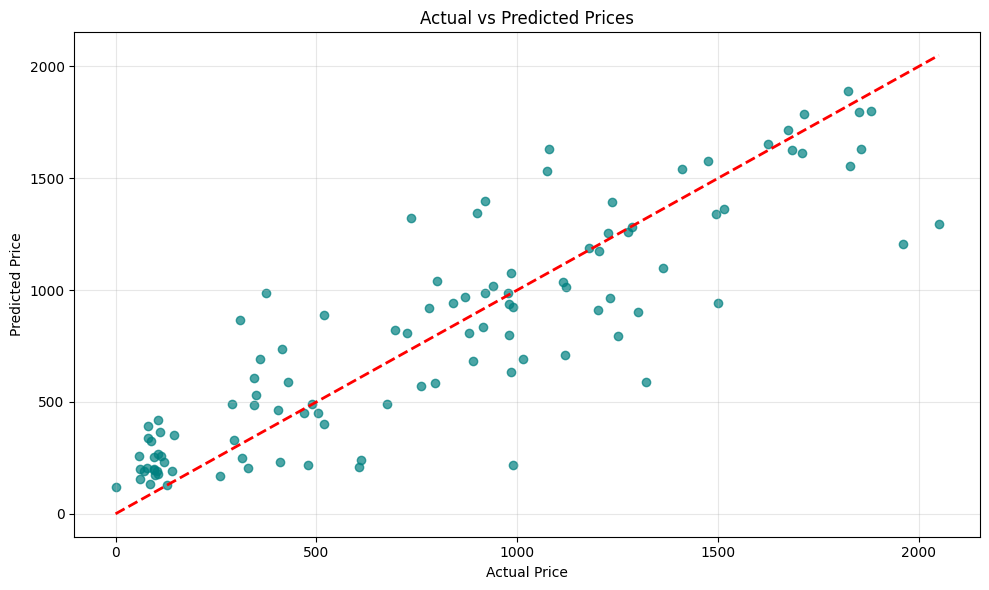

In [8]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_test, y_pred):
    """
    Plot actual vs predicted prices.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='teal')
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs Predicted Prices")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, y_pred)


Notice the data we have present has so much randomness shown in the graph. The standard deviation of some of the data from the BFL is quite an amount. Thus we can say, our model is doing actually good.

## Saving the Model

In [9]:
import pickle

def save_model(model, filename):
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved to {filename}")

In [10]:
save_model(model, "./model/model.pkl")

Model saved to ./model/model.pkl
